In [1]:
import argparse
import numpy as np
import pandas as pd
import os
import os.path
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 1000)

In [2]:
seq_num=100
mimic_path = '/data/chen/thesis/mimic_raw'
icd9 = pd.read_csv(os.path.join(mimic_path, 'DIAGNOSES_ICD.csv'))

# filter out rows with unrelated codes
icd9drop = icd9[~icd9['ICD9_CODE'].str.contains('E',na=False)]
icd9drop = icd9drop[~icd9drop['ICD9_CODE'].str.contains('V',na=False)]

#######################################################################
# TUNING: TRY WITH DIFFERENT # OF SEQ_NUM -> 7 OR 10
#######################################################################
icd9drop = icd9drop[icd9drop['SEQ_NUM'] <= seq_num]
icd9drop['icd'] = icd9drop['ICD9_CODE'].str[:3]
icd9drop["icd"] = pd.to_numeric(icd9drop["icd"])

In [152]:
icd9drop[:100]

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,icd
0,1297,109,172335,1.0,40301,403
1,1298,109,172335,2.0,486,486
2,1299,109,172335,3.0,58281,582
3,1300,109,172335,4.0,5855,585
4,1301,109,172335,5.0,4254,425
5,1302,109,172335,6.0,2762,276
6,1303,109,172335,7.0,7100,710
7,1304,109,172335,8.0,2767,276
8,1305,109,172335,9.0,7243,724
9,1306,109,172335,10.0,45829,458


In [3]:
heart = (icd9drop['icd'] >= 390) & (icd9drop['icd'] <= 459) | (icd9drop['icd'] == 785)
lungs = (icd9drop['icd'] >= 460) & (icd9drop['icd'] <= 519) | (icd9drop['icd'] == 786)
liver = (icd9drop['icd'] >= 570) & (icd9drop['icd'] <= 579) #liver, pancrease, gallbladder
gi =  (icd9drop['icd'] >= 530) & (icd9drop['icd'] <= 539) | (icd9drop['icd'] >= 555) & (icd9drop['icd'] <= 569) | (icd9drop['icd'] == 787)
kidney = (icd9drop['icd'] >= 580) & (icd9drop['icd'] <= 599) | (icd9drop['icd'] == 788) | (icd9drop['icd'] == 791)
# others = (not heart or not lungs or not liver or not gi or not kidney)

types = [heart,lungs,liver,gi,kidney]

hid = np.sort(icd9drop.HADM_ID.unique())
d = {'HADM_ID': hid}

df_pivot = pd.DataFrame(data=d, dtype=np.int64)
keys = ['heart','lungs','liver','gi','kidney']
# icd9drop['total'] = 1
# d = pd.DataFrame(icd9drop.groupby(["HADM_ID"]).sum()['total'])
# df_pivot = pd.merge(df_pivot, d, on="HADM_ID")
for idx, item in enumerate(types):
    icd9drop[keys[idx]]=0
    icd9drop.loc[icd9drop[item].index, keys[idx]] = 1
    d = pd.DataFrame(icd9drop.groupby(["HADM_ID"]).sum()[keys[idx]])
    df_pivot = pd.merge(df_pivot, d, on="HADM_ID")

# df_pivot['others'] = df_pivot['total'] - (df_pivot['heart'] + df_pivot['lungs'] + df_pivot['liver'] + df_pivot['gi'] + df_pivot['kidney'])      
df_pivot['total'] = df_pivot['heart'] + df_pivot['lungs'] + df_pivot['liver'] + df_pivot['gi'] + df_pivot['kidney']

category_name = ['heart','lungs','liver','gi','kidney']

for idx, item in enumerate(category_name):
    df_pivot[category_name[idx]+"%"] = round(df_pivot[category_name[idx]]/df_pivot['total'],4)


In [24]:
# df_pivot
# df_pivot.to_csv('icd_histo.csv',index=False)
df_pivot = read_csv('icd_histo.csv')

In [5]:
df_pivot.describe()

,HADM_ID,heart,lungs,liver,gi,kidney,total,heart%,lungs%,liver%,gi%,kidney%
count,56669.000000,56669.000000,56669.00000,56669.000000,56669.000000,56669.000000,56669.000000,48827.000000,48827.000000,48827.000000,48827.000000,48827.000000
mean,149979.277083,2.574618,0.81736,0.257213,0.426441,0.564806,4.640438,0.557655,0.181971,0.053206,0.095961,0.111207
std,28878.145388,2.319558,1.13281,0.722278,0.800762,0.869505,3.469145,0.313660,0.240213,0.143537,0.179331,0.167218
min,100001.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,124966.000000,1.000000,0.00000,0.000000,0.000000,0.000000,2.000000,0.333300,0.000000,0.000000,0.000000,0.000000
50%,150032.000000,2.000000,0.00000,0.000000,0.000000,0.000000,4.000000,0.571400,0.100000,0.000000,0.000000,0.000000
75%,174962.000000,4.000000,1.00000,0.000000,1.000000,1.000000,7.000000,0.800000,0.285700,0.000000,0.142900,0.200000
max,199999.000000,17.000000,9.00000,9.000000,8.000000,8.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000


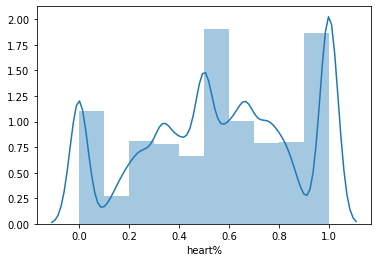

In [6]:
ax = sns.distplot(df_pivot['heart%'], bins=10)
plt.show()

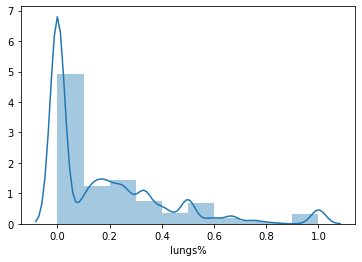

In [17]:
ax = sns.distplot(df_pivot['lungs%'], bins=10)
plt.show()

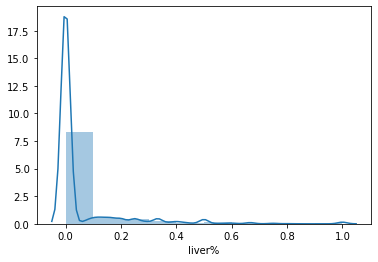

In [18]:
ax = sns.distplot(df_pivot['liver%'], bins=10)
plt.show()

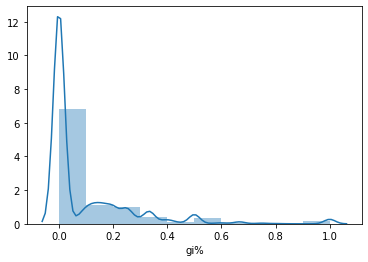

In [19]:
ax = sns.distplot(df_pivot['gi%'], bins=10)
plt.show()

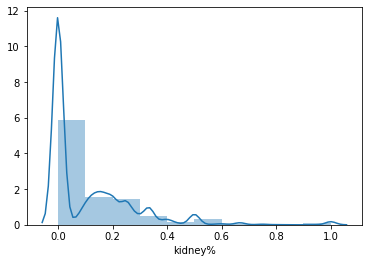

In [20]:
ax = sns.distplot(df_pivot['kidney%'], bins=10)
plt.show()

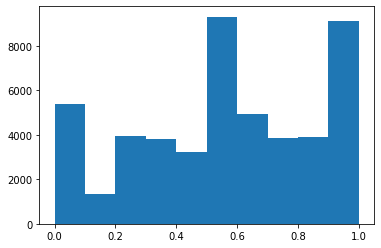

In [11]:
plt.hist(df_pivot['heart%'], bins = 10)
plt.show()

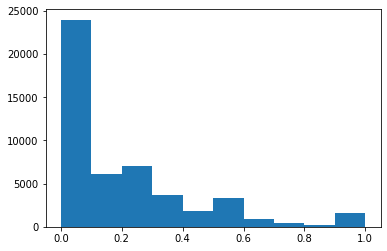

In [12]:
plt.hist(df_pivot['lungs%'], bins = 10)
plt.show()

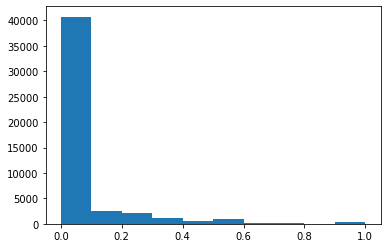

In [13]:
plt.hist(df_pivot['liver%'], bins = 10)
plt.show()

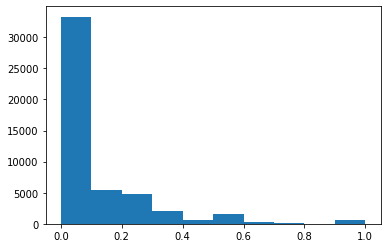

In [14]:
plt.hist(df_pivot['gi%'], bins = 10)
plt.show()

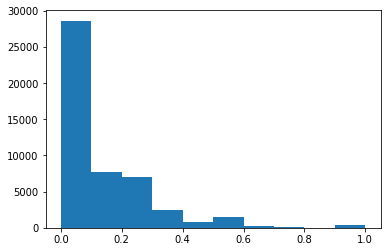

In [15]:
plt.hist(df_pivot['kidney%'], bins = 10)
plt.show()

In [16]:
# df_pivot.loc[df_pivot['HADM_ID'] == 172335]